In [5]:
from __future__ import annotations
!{sys.executable} -m pip install seaborn --user
!{sys.executable} -m pip install matplotlib --user

import json
import os
import pandas
import re
import seaborn

from glob import glob
from matplotlib import pyplot
from os import path
from pandas import DataFrame
from typing import Any, Callable, Dict, List, Optional, Sequence, Set, Tuple, Union

%matplotlib inline

/bin/sh: {sys.executable}: command not found
/bin/sh: {sys.executable}: command not found


In [6]:
class DataSet:

    _converters: Dict[str, Callable] = {
        'concurrency': int,
        'documentCount': int,
        'connectionEndpointRediscovery': lambda value: str(value).capitalize() == 'True',
        'threadCount': int,
    }

    def __init__(self, name: str, environment: str, codebase_names: list, category_names: list) -> None:
        self._scenarios = set()
        self._name = name
        self._environment = environment
        self._category_names = category_names
        self._codebase_names = codebase_names

    # region Properties

    def category_names(self) -> List[str]:
        return self._category_names

    def codebases(self) -> Sequence[str]:
        for codebase in self._codebase_names:
            yield codebase

    def name(self) -> str:
        return self._name

    def environment(self) -> str:
        return self._environment

    def scenarios(self) -> Set[str]:
        return self._scenarios

    # endregion

    # region Methods

    def consolidate_frames(self, home: str) -> (DataSet, List[Tuple[DataFrame, str]]):

        performance_data: Optional[DataFrame] = None
        compute_data: Optional[DataFrame] = None
        network_data: Optional[DataFrame] = None

        for codebase in self.codebases():
            os.chdir('{0}/azure-cosmos-benchmark.results.{1}/{2}'.format(self.name(), self.environment(), codebase))
            performance_data = self._consolidate_performance_data(codebase, performance_data)
            network_data = self._consolidate_network_data(codebase, network_data)
            compute_data = self._consolidate_compute_data(codebase, compute_data)
            os.chdir(home)

        performance_data_filename: str = os.path.join(home, self.name(), 'performance_data.csv')
        performance_data.to_csv(performance_data_filename, index=False, encoding='utf-8-sig')

        network_data_filename: str = os.path.join(home, self.name(), 'network_data.csv')
        network_data.to_csv(network_data_filename, index=False, encoding='utf-8-sig')

        compute_data_filename: str = os.path.join(home, self.name(), 'compute_data.csv')
        compute_data.to_csv(compute_data_filename, index=False, encoding='utf-8-sig')

        return self, [
               (performance_data, performance_data_filename),
               (network_data, network_data_filename),
               (compute_data, compute_data_filename)]

    @staticmethod
    def convert(parameter: str, value: str) -> Any:
        converter = DataSet._converters.get(parameter, str)
        return converter(value)

    def read_frame(self, filename: str, codebase: str) -> DataFrame:

        frame: DataFrame = pandas.read_csv(filename, skipinitialspace=True)
        hue = dict()

        if 'codebase' in self._category_names:
            hue['codebase'] = codebase

        for match in re.finditer('(\w+)=([^;]+);', filename):
            parameter : str = match.group(1)
            value = DataSet.convert(parameter, match.group(2))
            if parameter in self._category_names:
                hue[parameter] = value
            frame[parameter] = value

        scenario: str = json.dumps(hue)

        frame['codebase'] = codebase
        frame['scenario'] = scenario

        self._scenarios.add(scenario)

        return frame

    def _add_column_period(self, frame: DataFrame) -> DataFrame:

        frame.sort_values(by=['scenario', 'concurrency', 'Time'], inplace = True)

        for document_count in pandas.unique(frame['documentCount']):
            for scenario in pandas.unique(frame['scenario']):
                for concurrency in pandas.unique(frame['concurrency']):
                    frame.loc[
                        frame.scenario.eq(scenario) &
                        frame.concurrency.eq(concurrency) &
                        frame.documentCount.eq(document_count), 'period'] = pandas.to_numeric(
                            frame.loc[
                                frame.scenario.eq(scenario) &
                                frame.concurrency.eq(concurrency) &
                                frame.documentCount.eq(document_count), 'Time'].rank(method='dense'), downcast='signed')
        return frame

    def _consolidate_compute_data(self, codebase: str, frame: DataFrame) -> DataFrame:

        data: DataFrame = pandas.concat([data_set.read_frame(p, codebase) for p in glob('*.top.csv') if path.exists(p)])
        data['VIRT'] = data['VIRT'].transform(DataSet._memory_unit_to_gib)
        data = self._add_column_period(data)

        return data if frame is None else frame.append(data)

    def _consolidate_network_data(self, codebase: str, frame: DataFrame) -> DataFrame:

        data: DataFrame = pandas.concat([data_set.read_frame(p, codebase) for p in glob('*.ss.csv') if path.exists(p)])
        data = self._add_column_period(data)

        return data if frame is None else frame.append(data)

    @staticmethod
    def _consolidate_performance_data(codebase: str, frame: DataFrame) -> DataFrame:
        paths: List[str] = [os.path.join(d, 'Latency.csv') for d in glob('*.perf')]
        subset: DataFrame = pandas.concat([data_set.read_frame(p, codebase) for p in paths if path.exists(p)])
        return subset if frame is None else frame.append(subset)

    @staticmethod
    def _memory_unit_to_gib(value: Union[str, int]) -> float:

        if type(value) is str:
            unit: str = value[-1]
            if unit == 'b':
                return float(value[0:-1]) / (1024 * 1024 * 1024)
            if unit == 'k':
                return float(value[0:-1]) / (1024 * 1024)
            if unit == 'm':
                return float(value[0:-1]) / 1024
            if unit == 'g':
                return float(value[0:-1])
            return float(value) / (1024 * 1024 * 1024)

        return value / (1024 * 1024 * 1024)

    # endregion

In [7]:
# Consolidate data

cwd : str = os.getcwd()
tables: List[Tuple] = []

try:
    os.chdir('..')

    for data_set in [
        DataSet('2020-09-04.1', 'prod-03', ['4.X.develop', '4.X.master'], [
            'codebase',
            'operation',
            'connectionEndpointRediscovery'])]:
        tables.append(data_set.consolidate_frames(os.getcwd()))

finally:
    os.chdir(cwd)

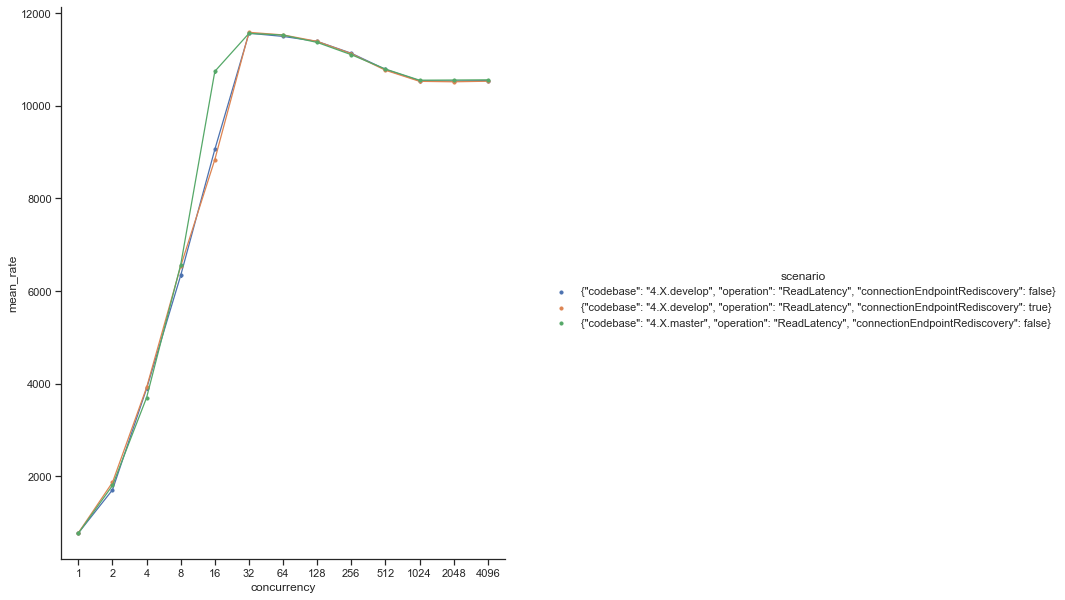

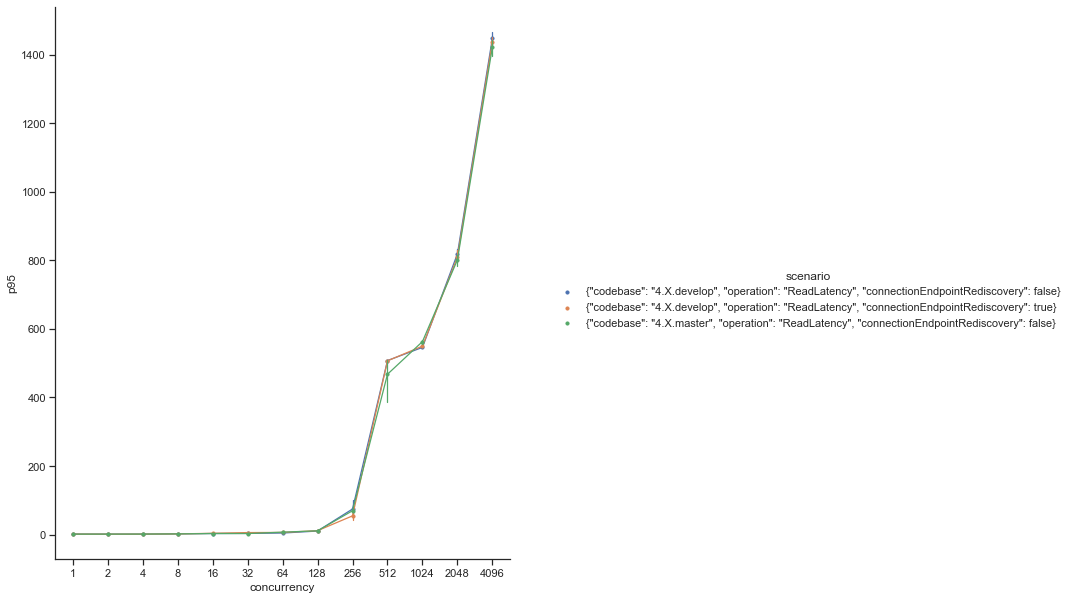

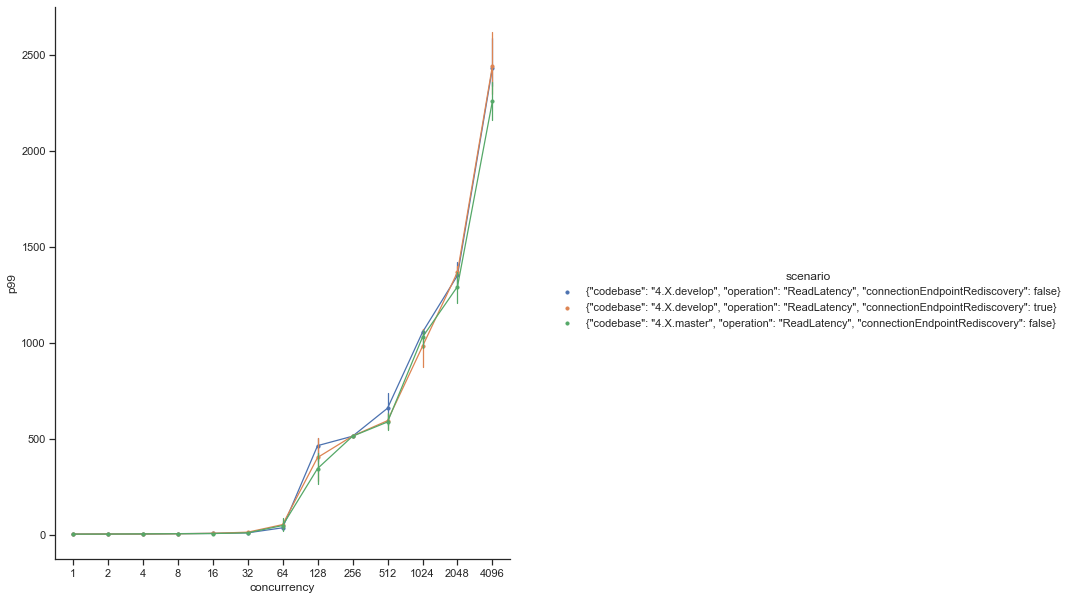

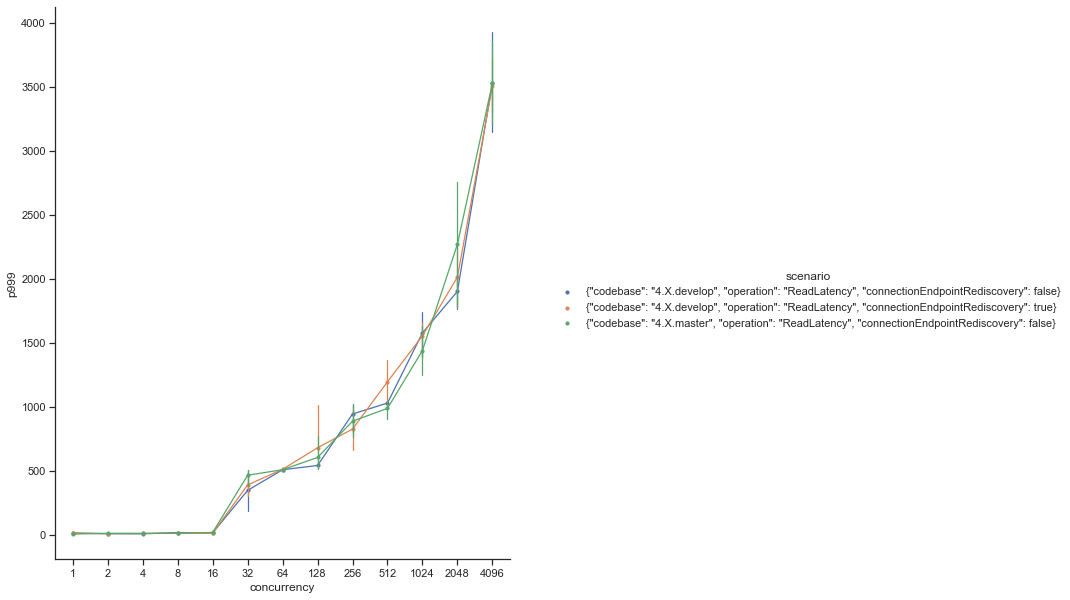

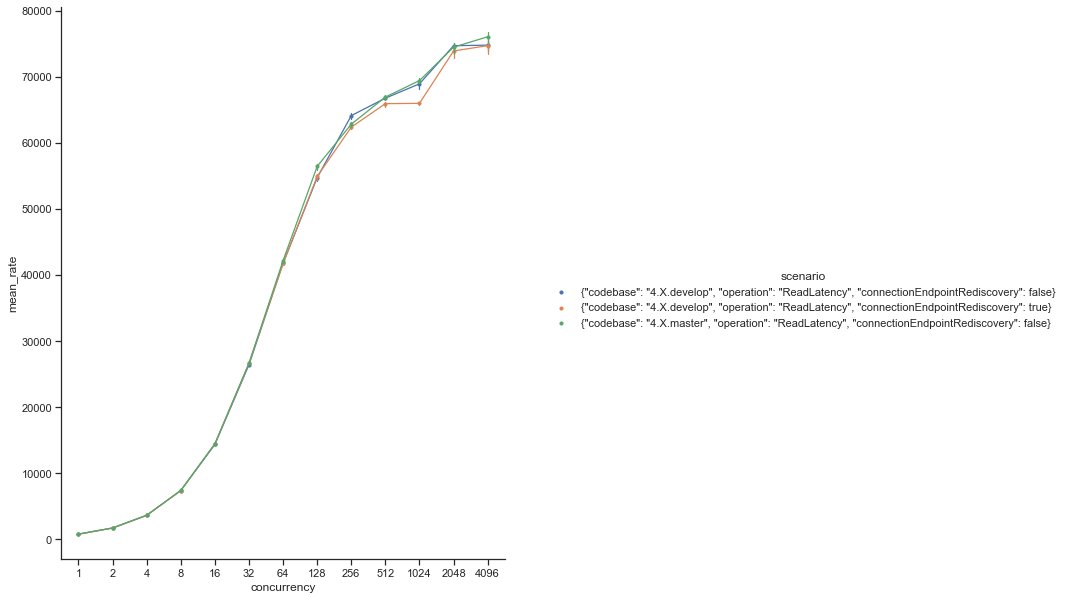

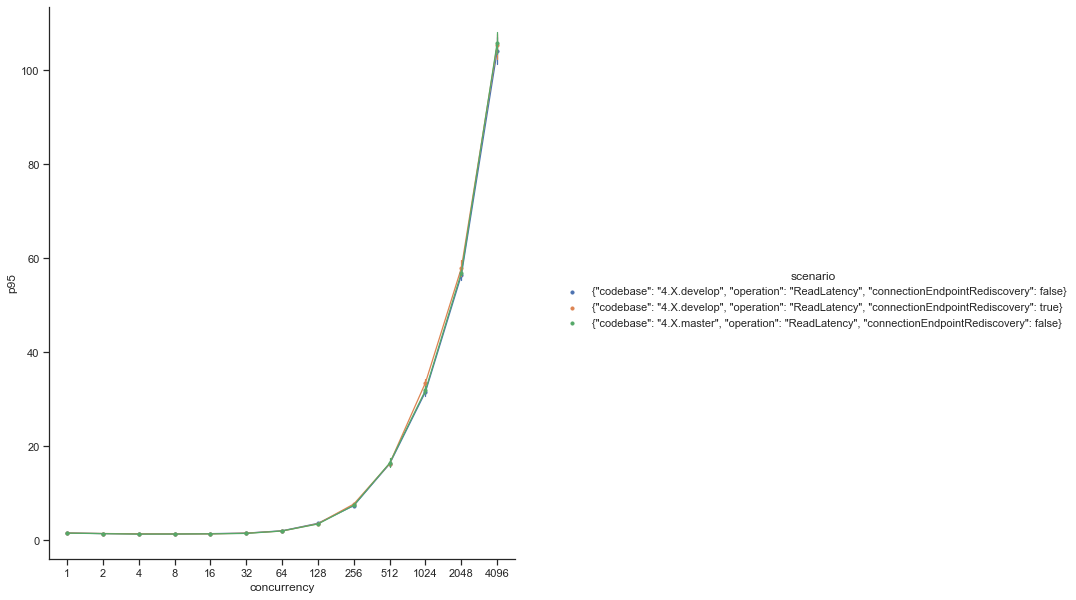

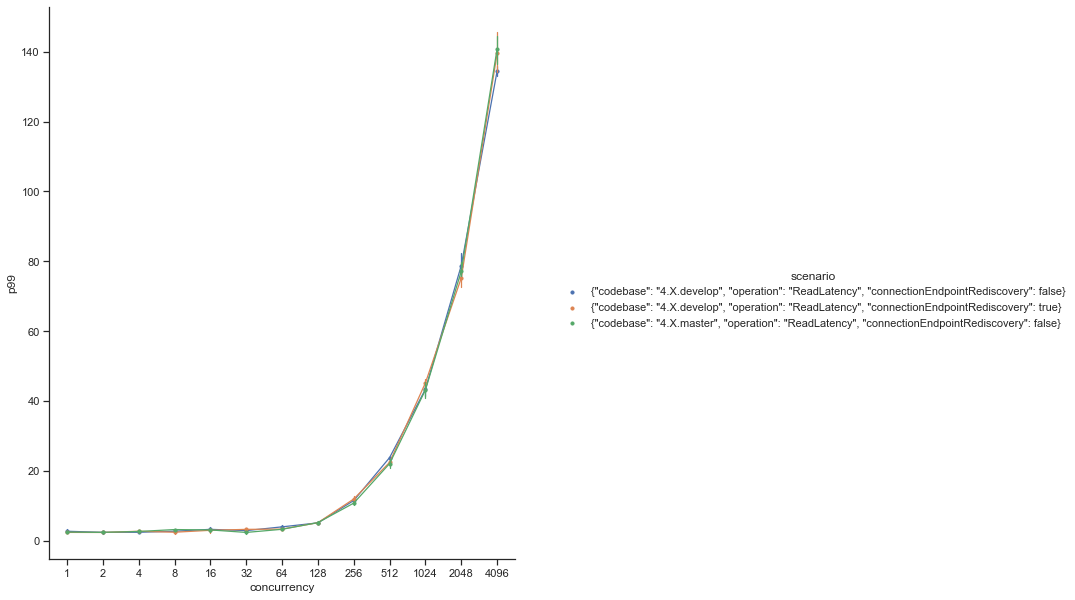

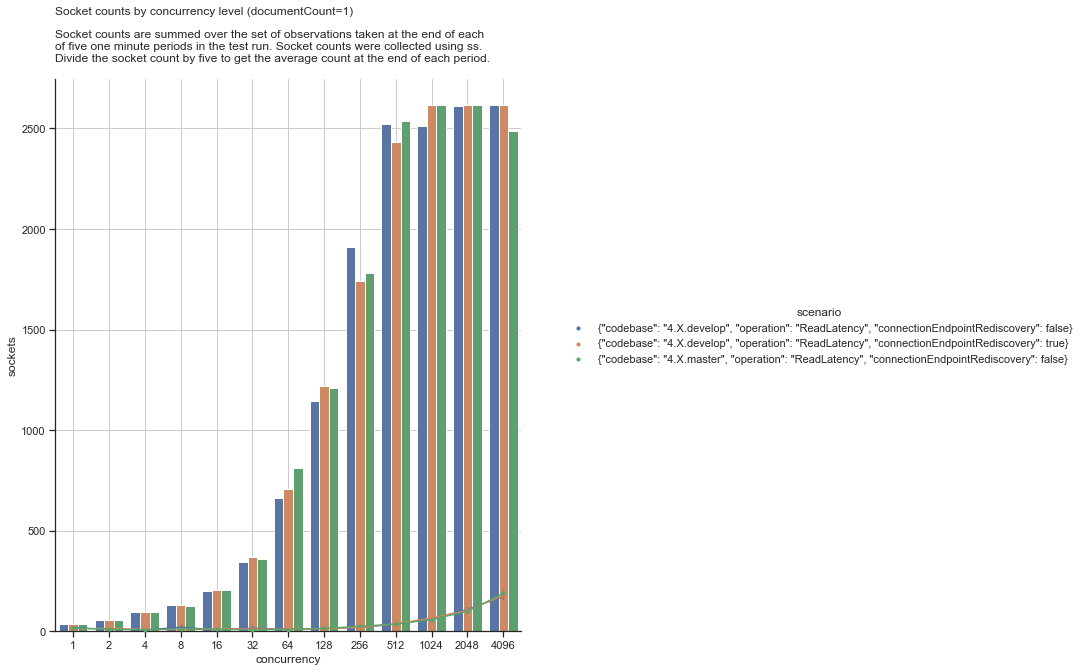

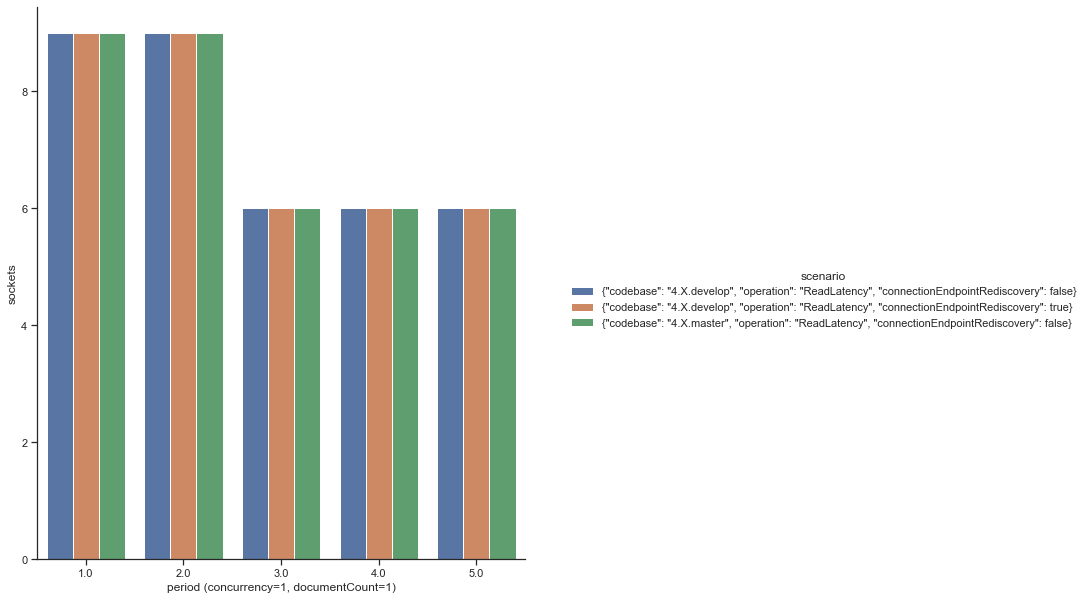

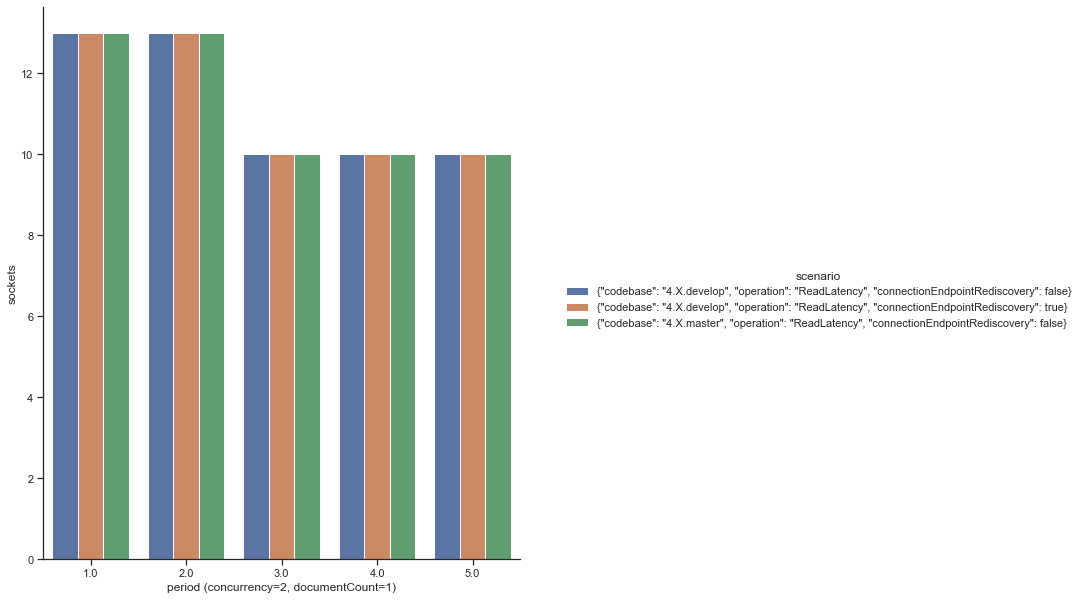

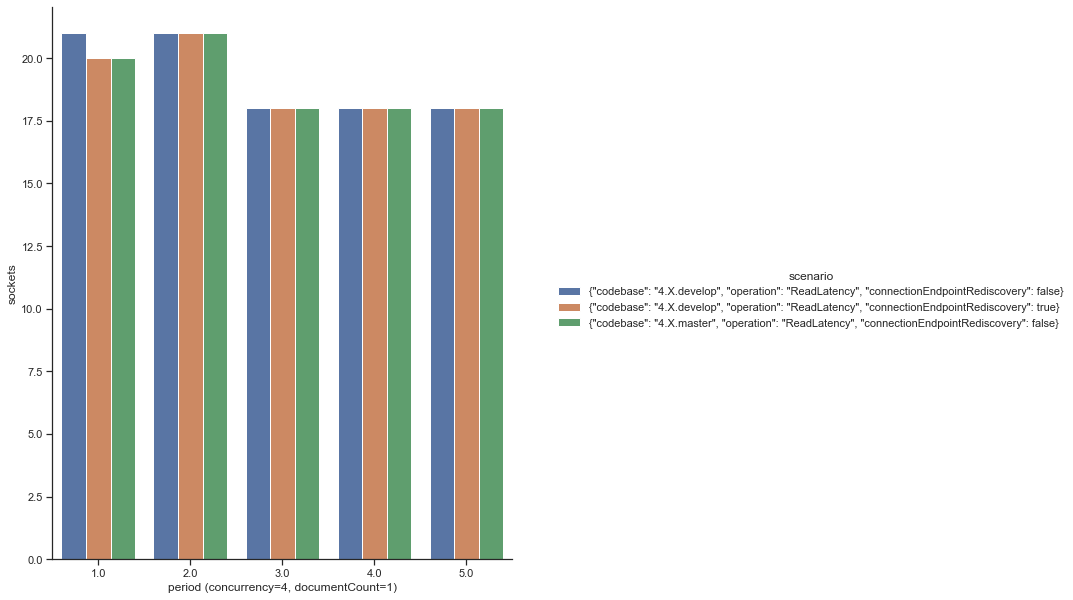

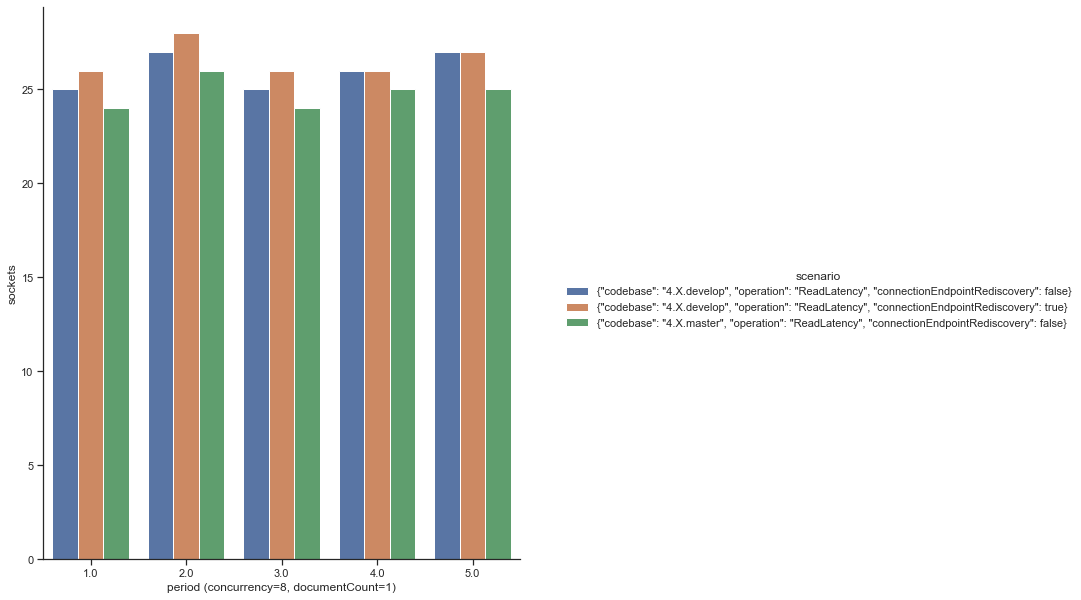

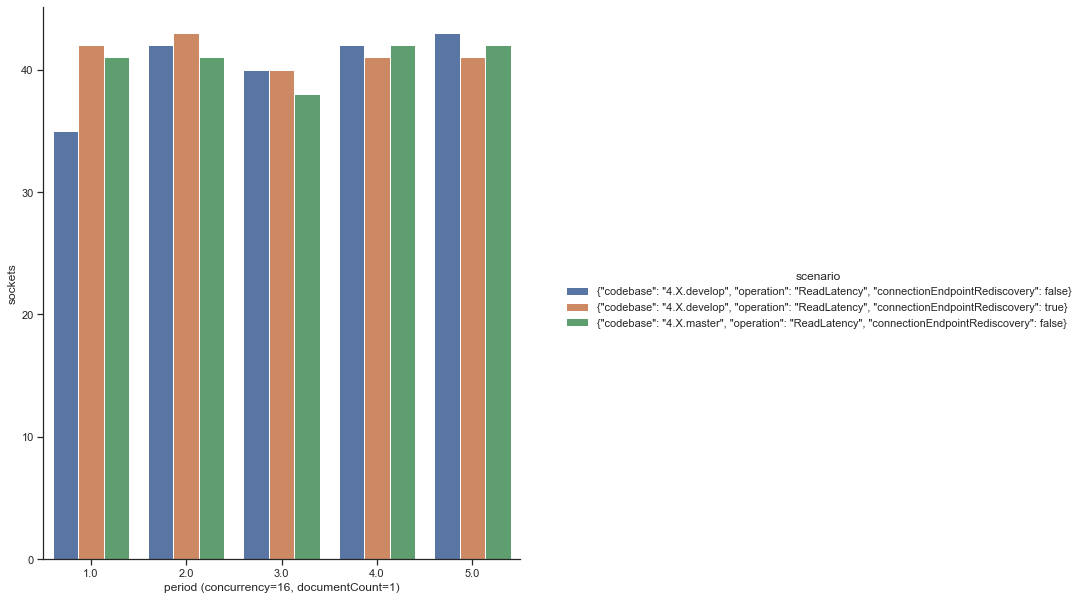

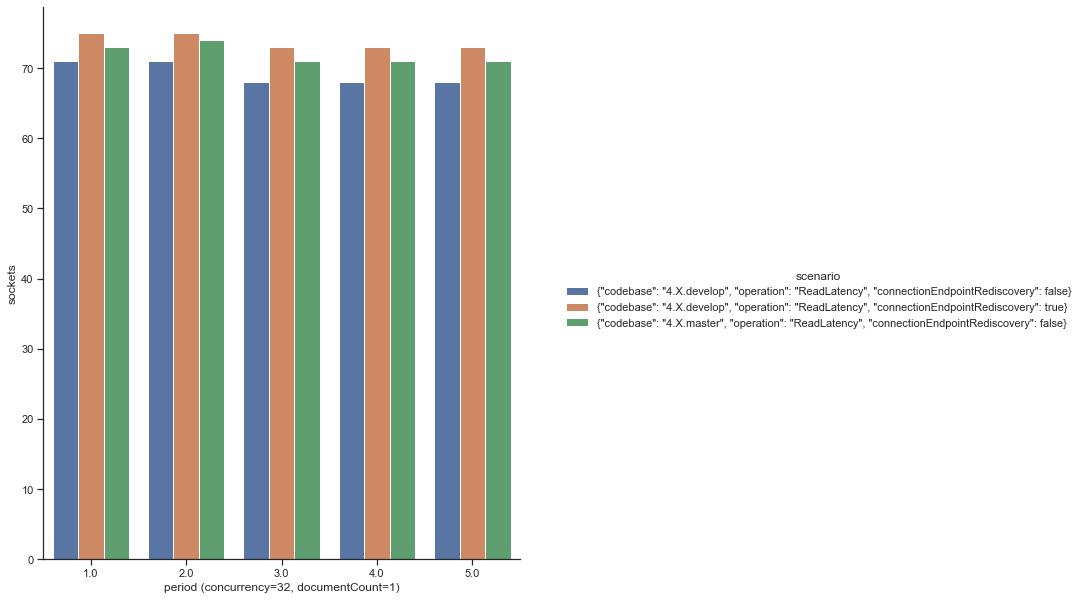

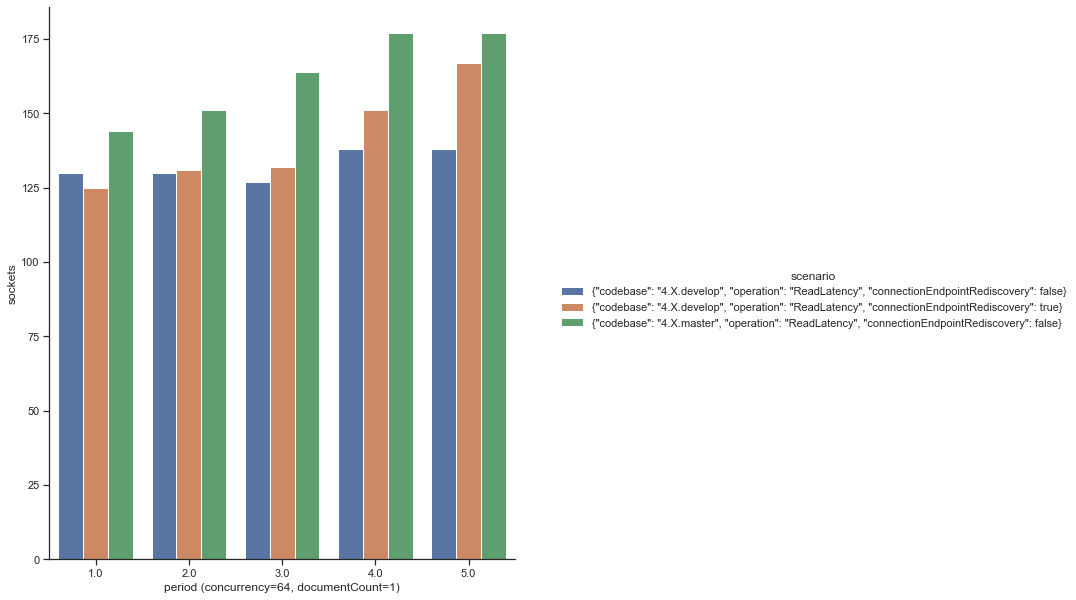

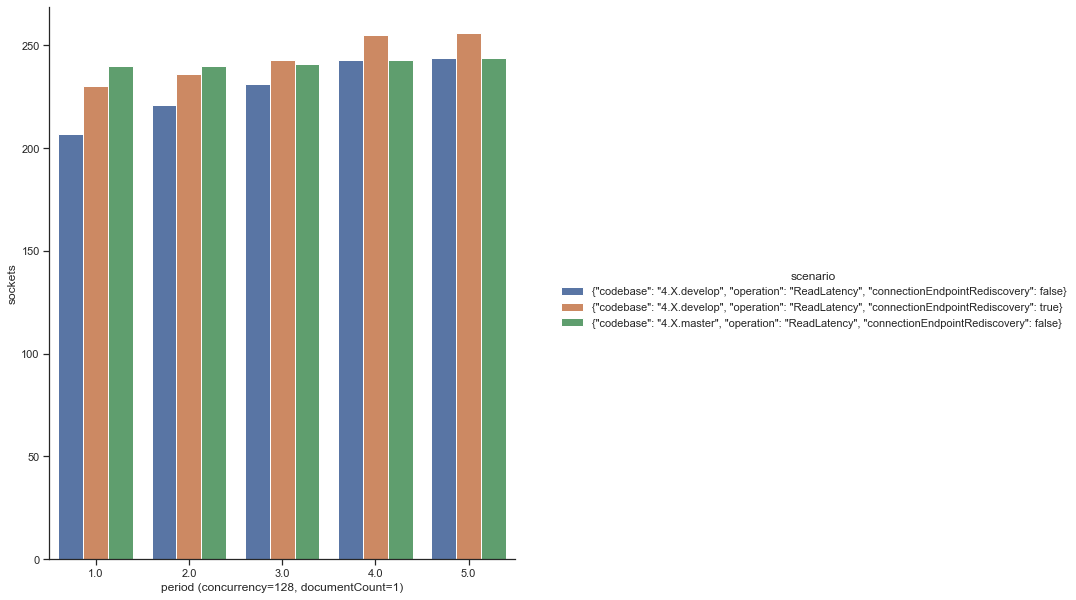

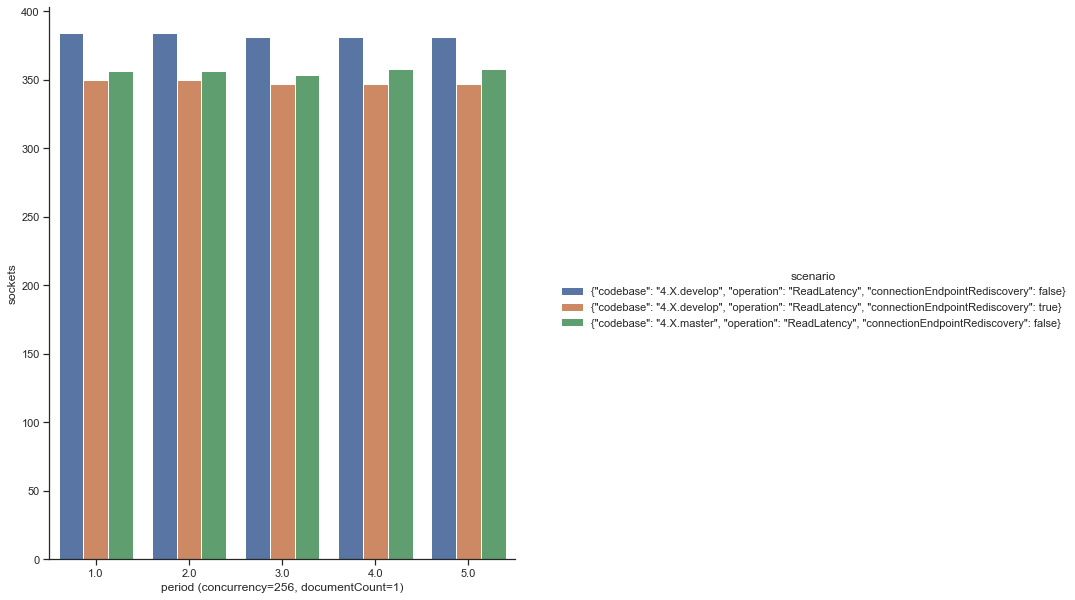

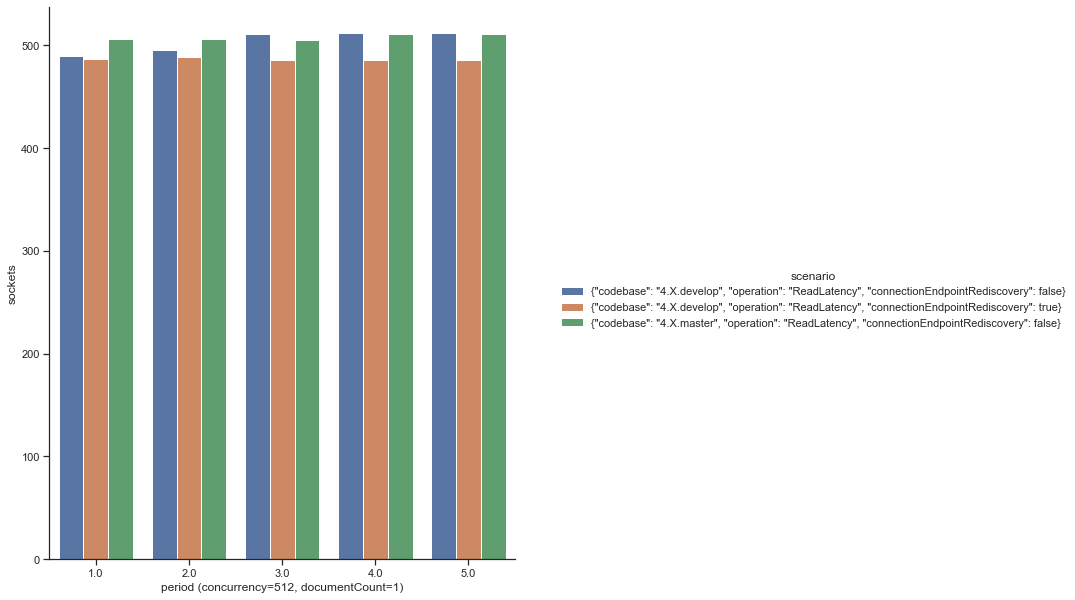

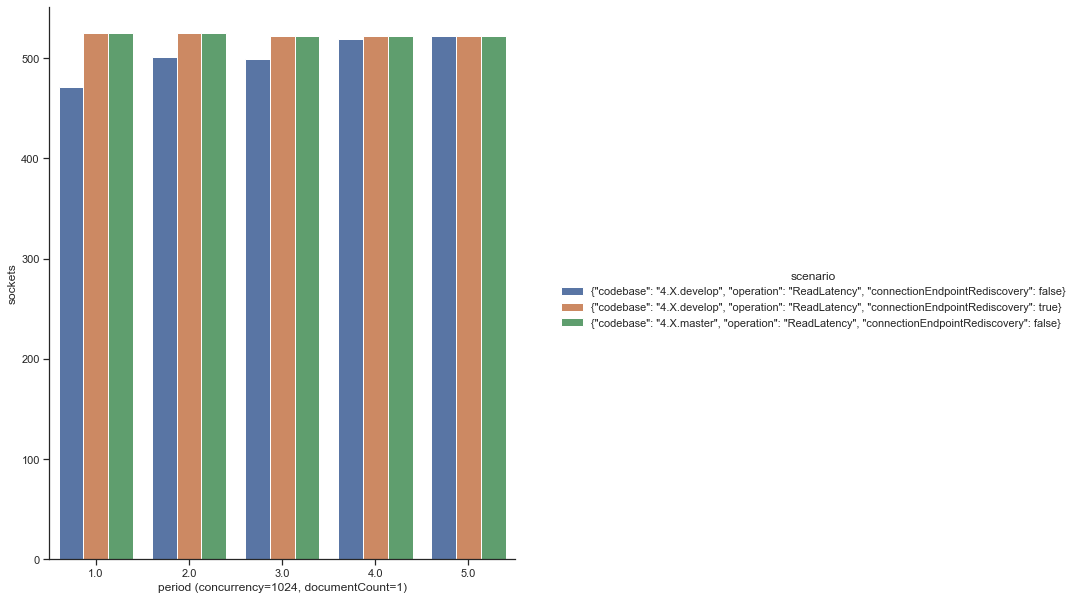

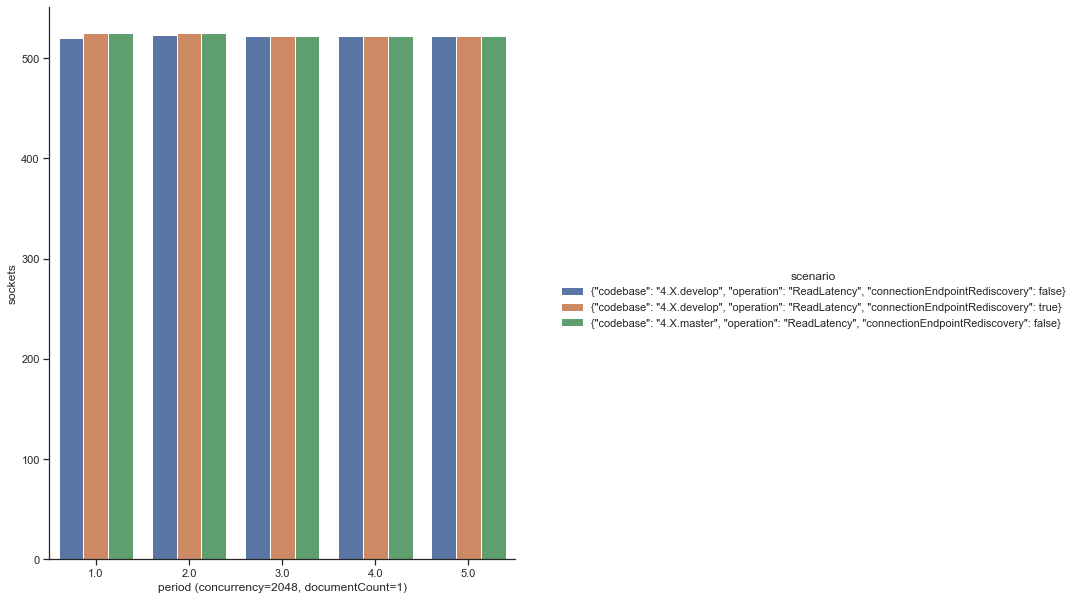

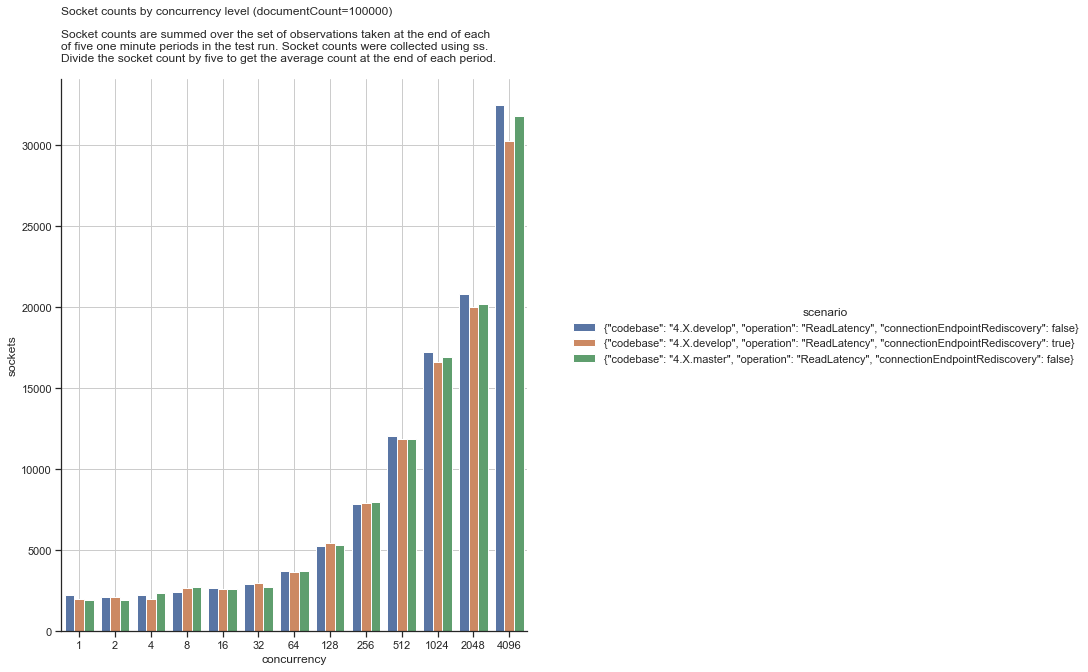

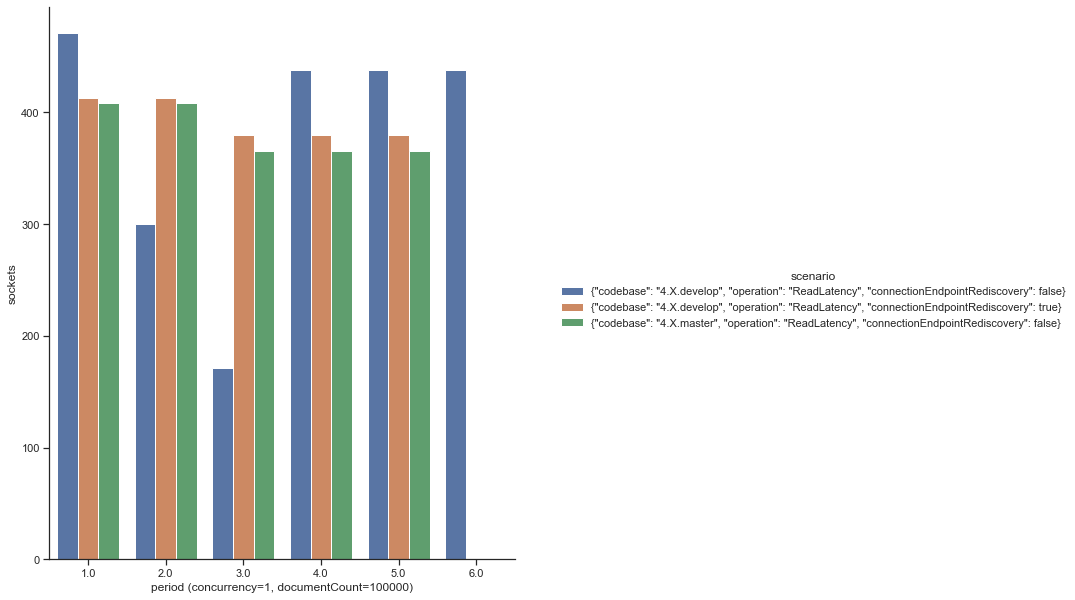

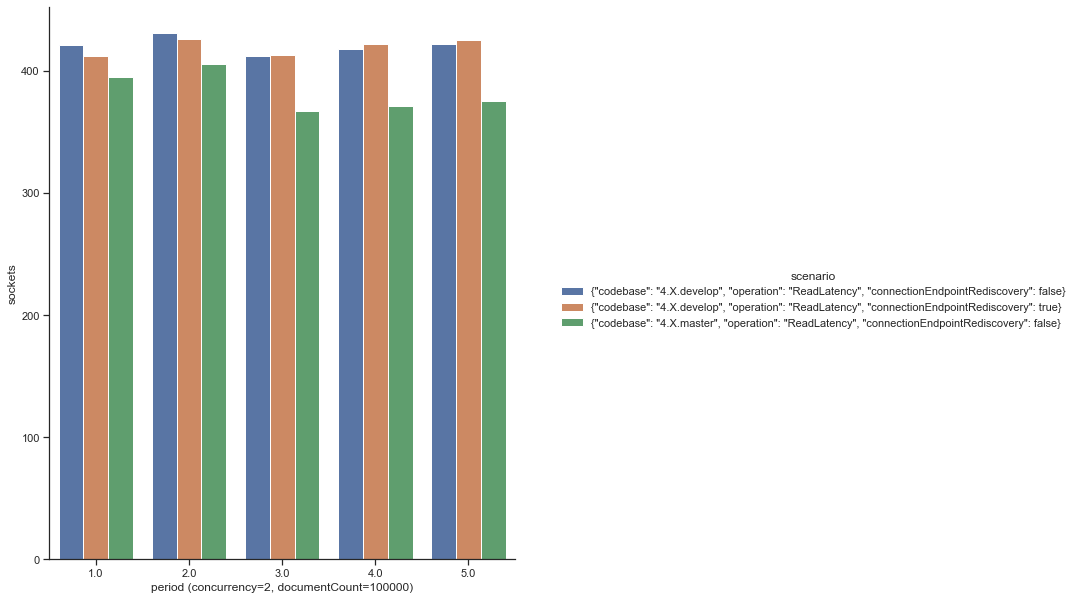

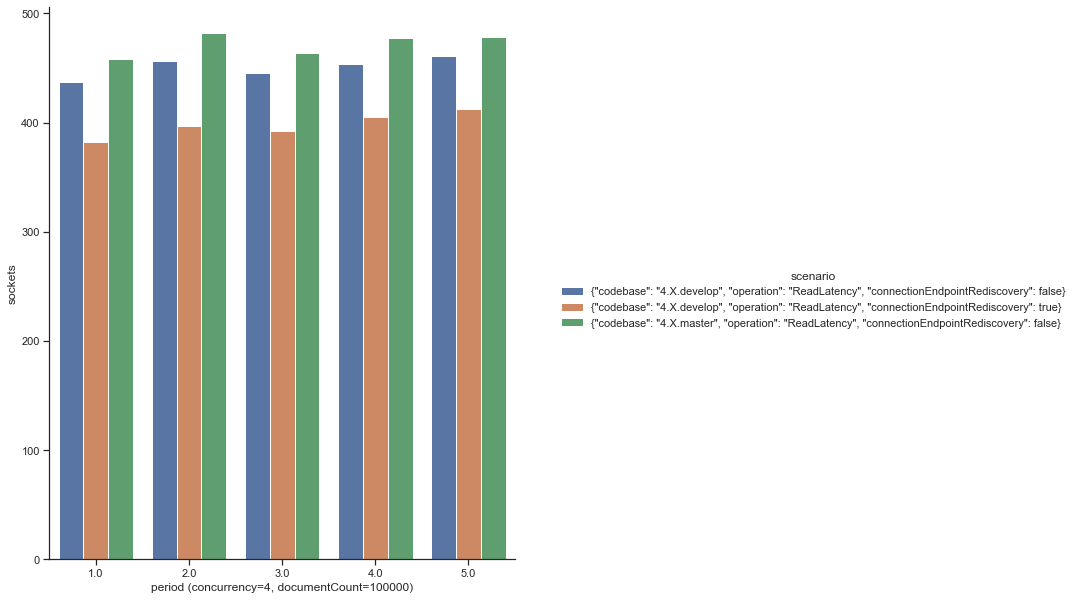

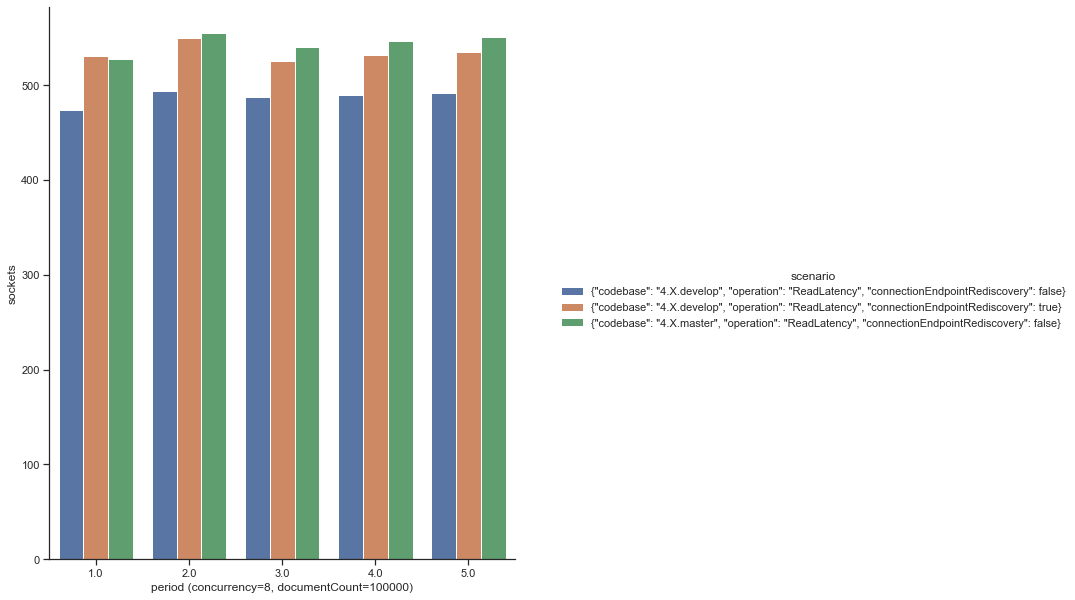

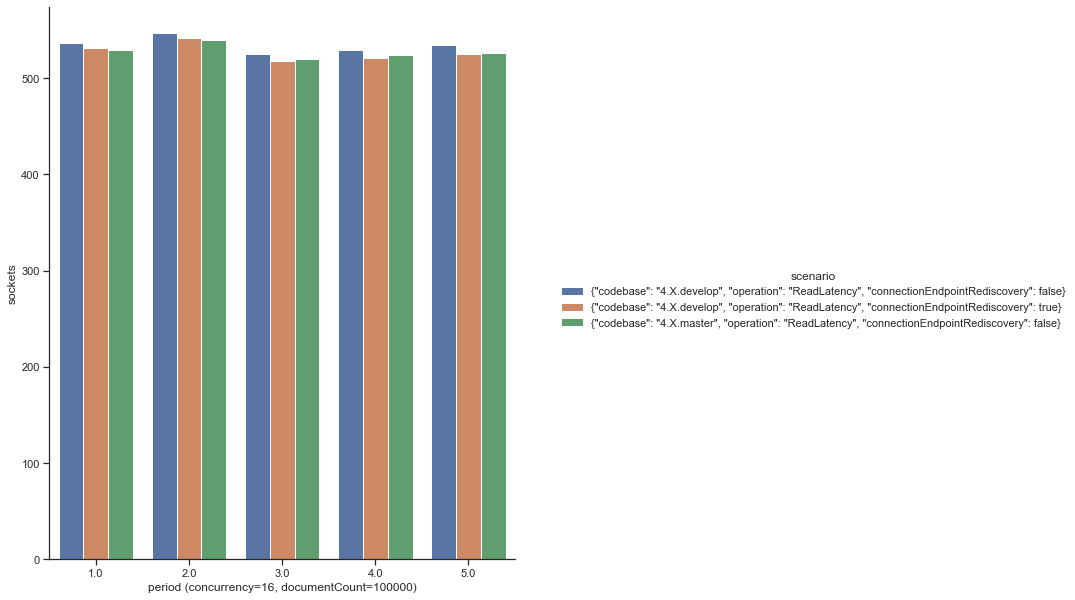

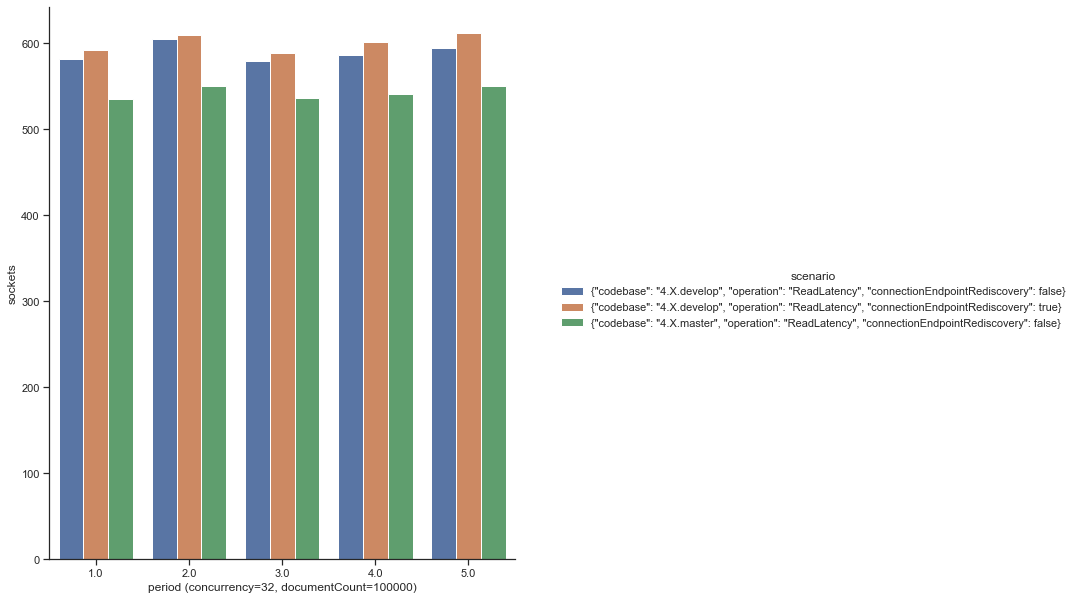

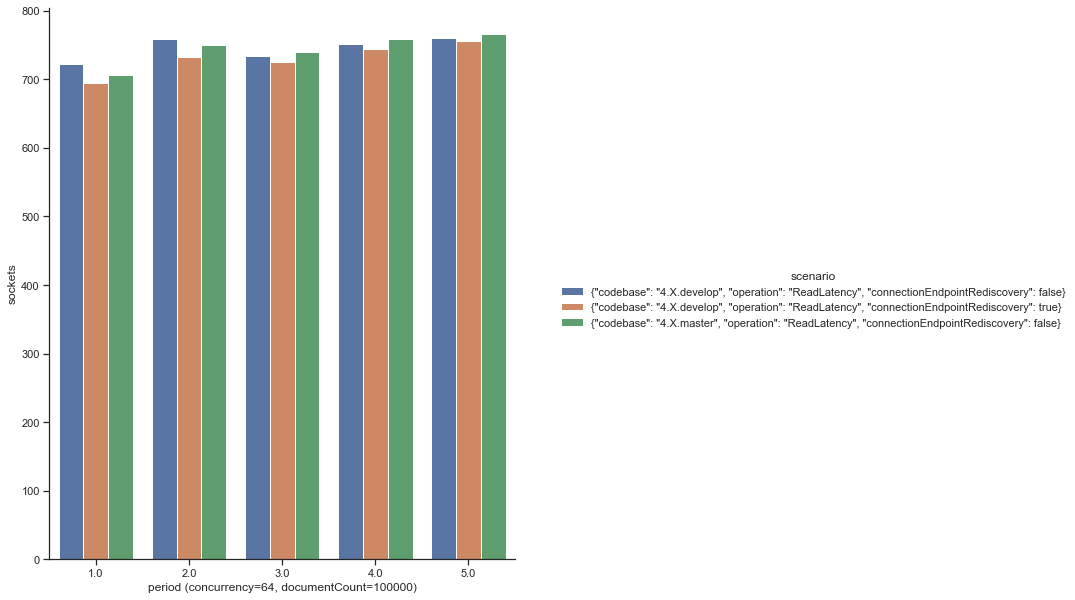

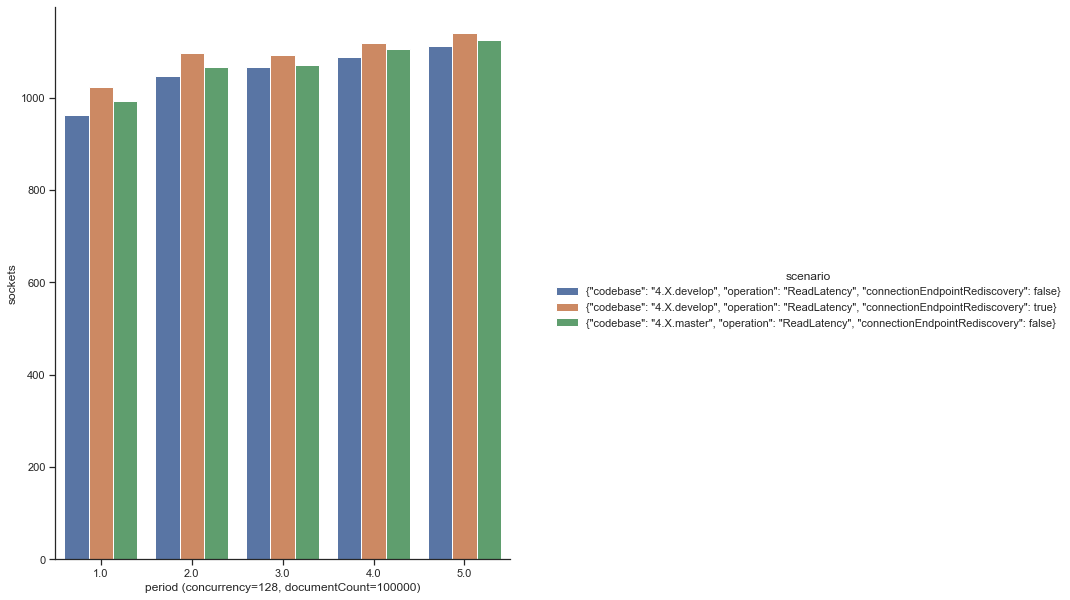

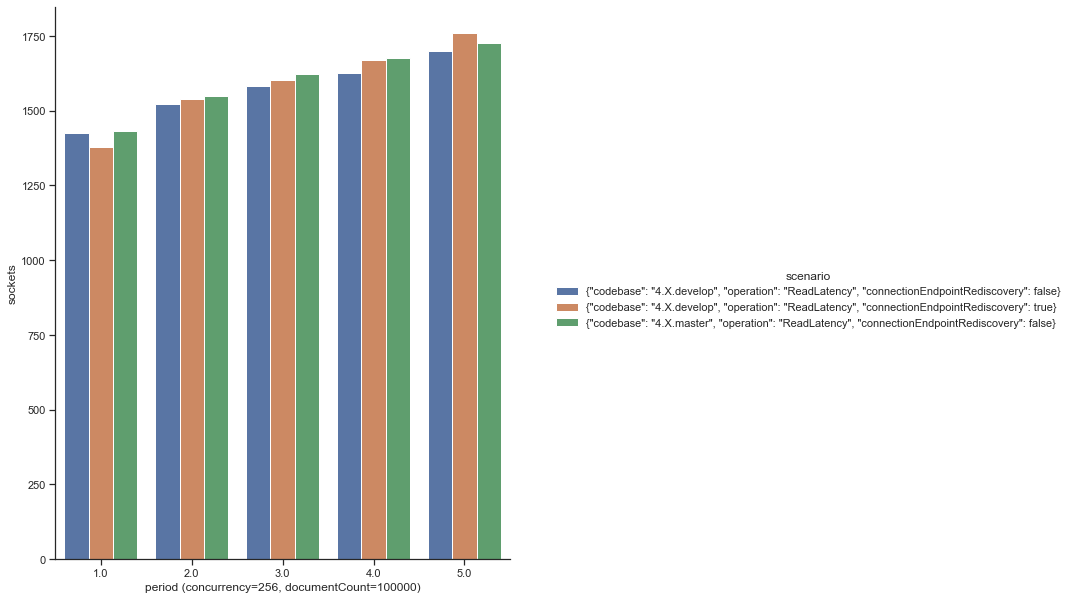

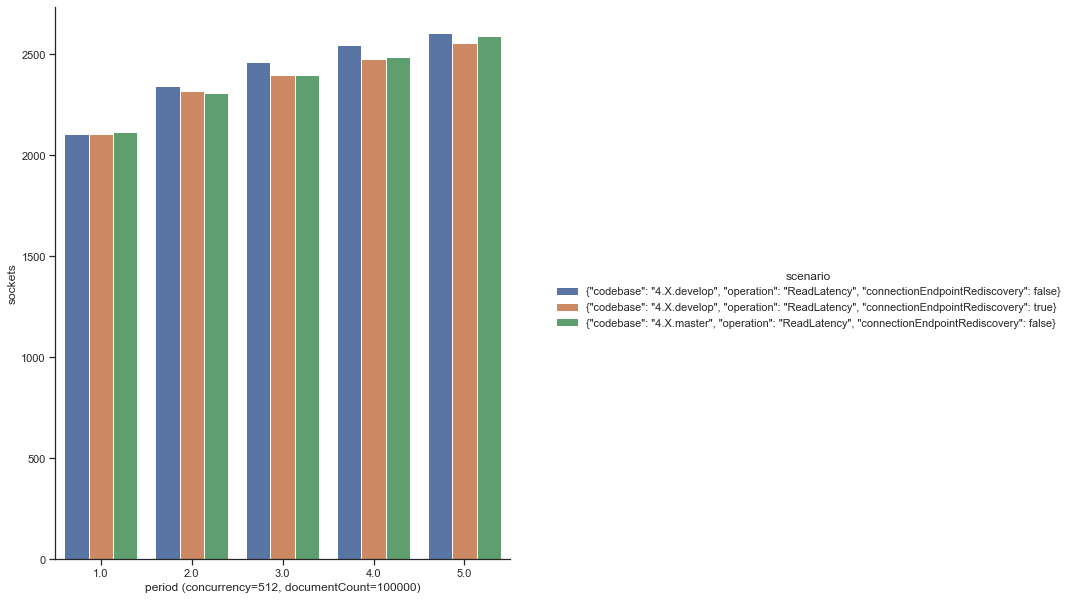

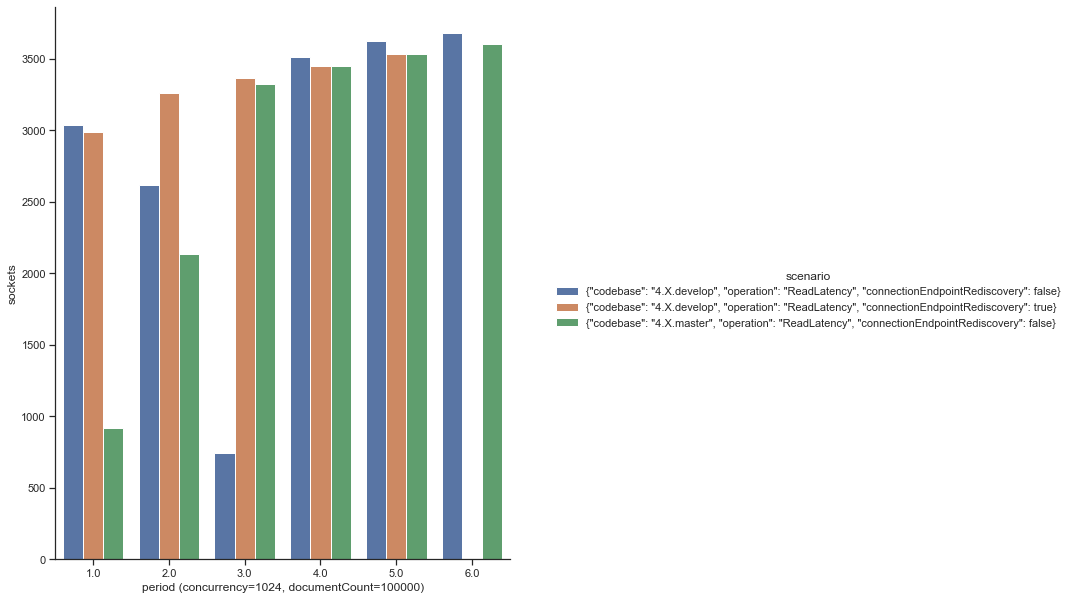

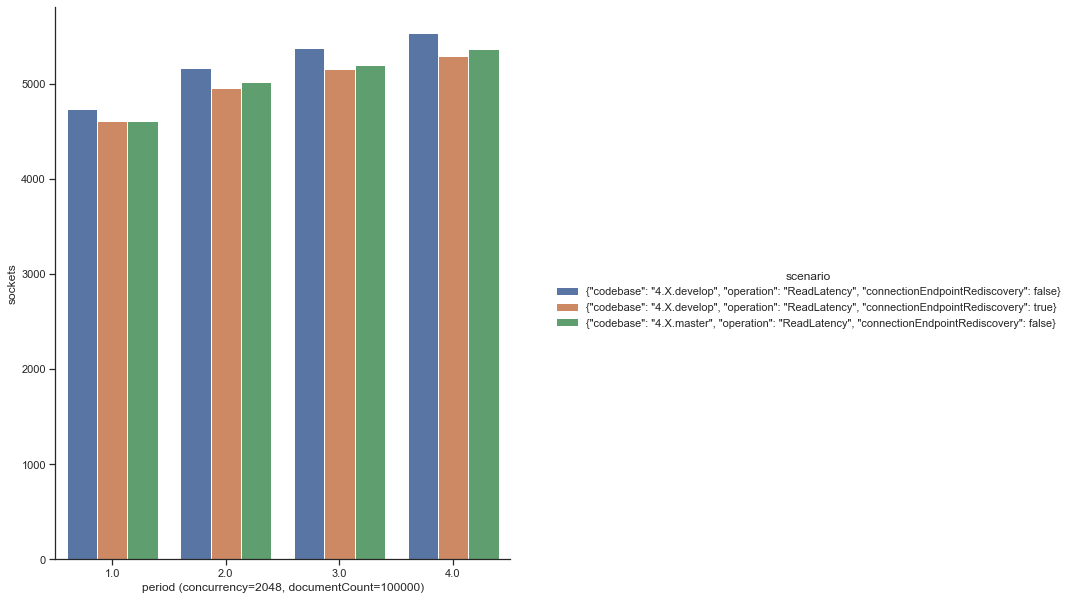

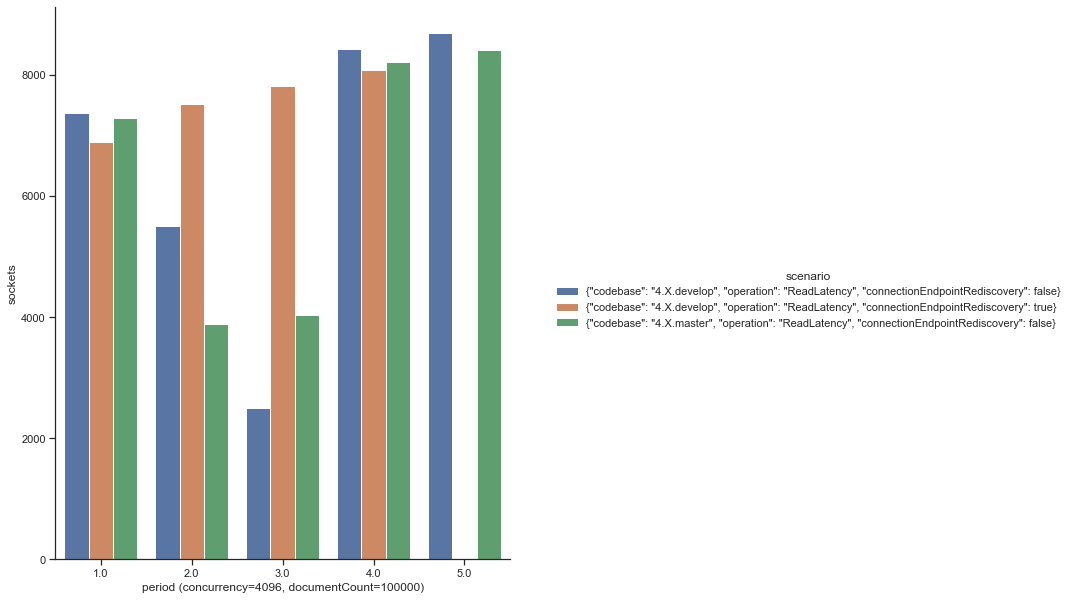

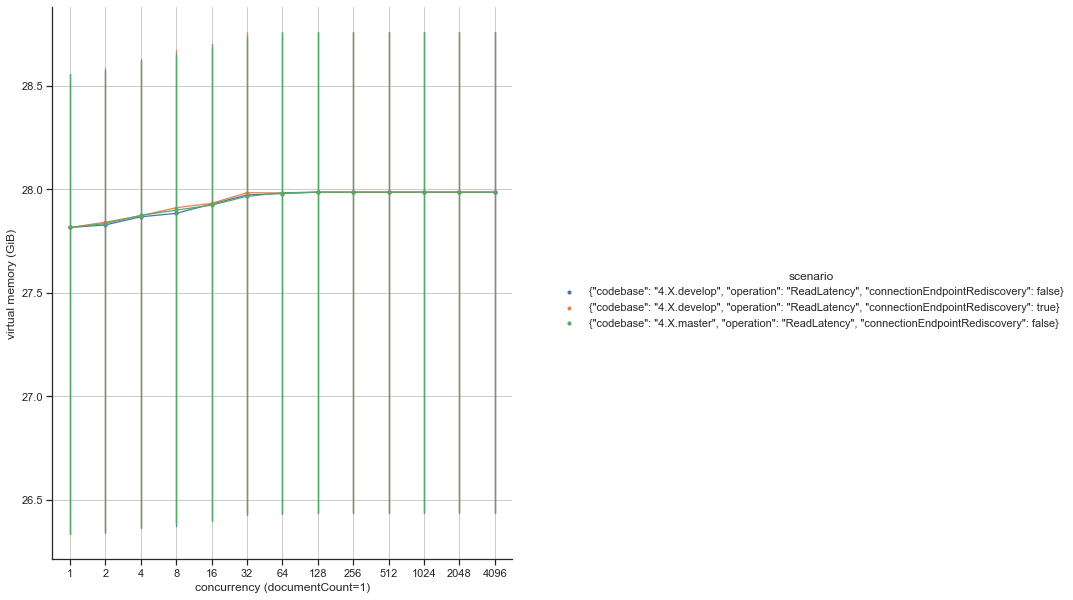

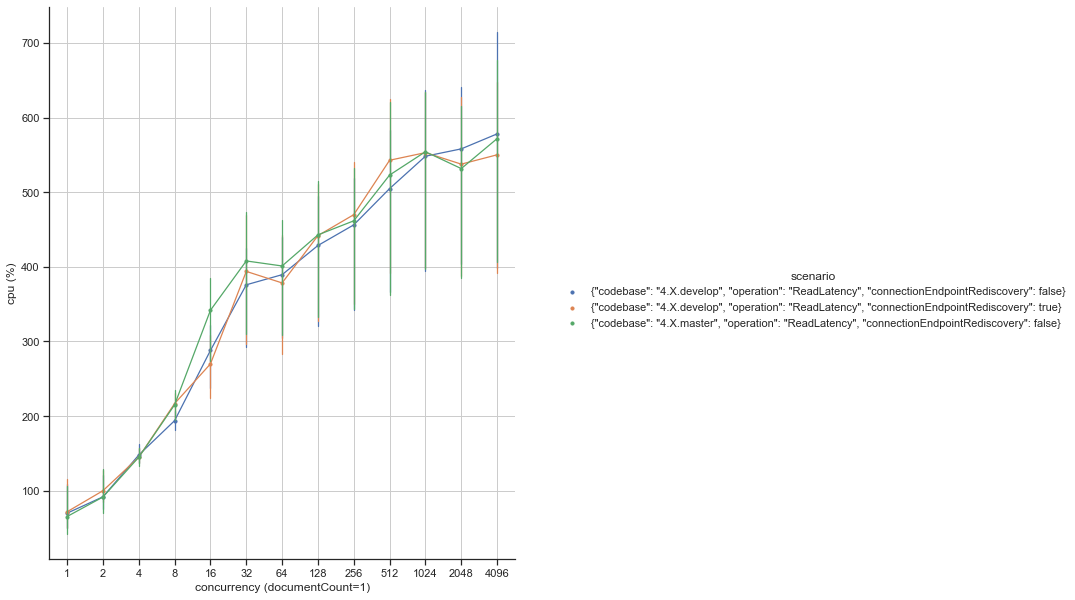

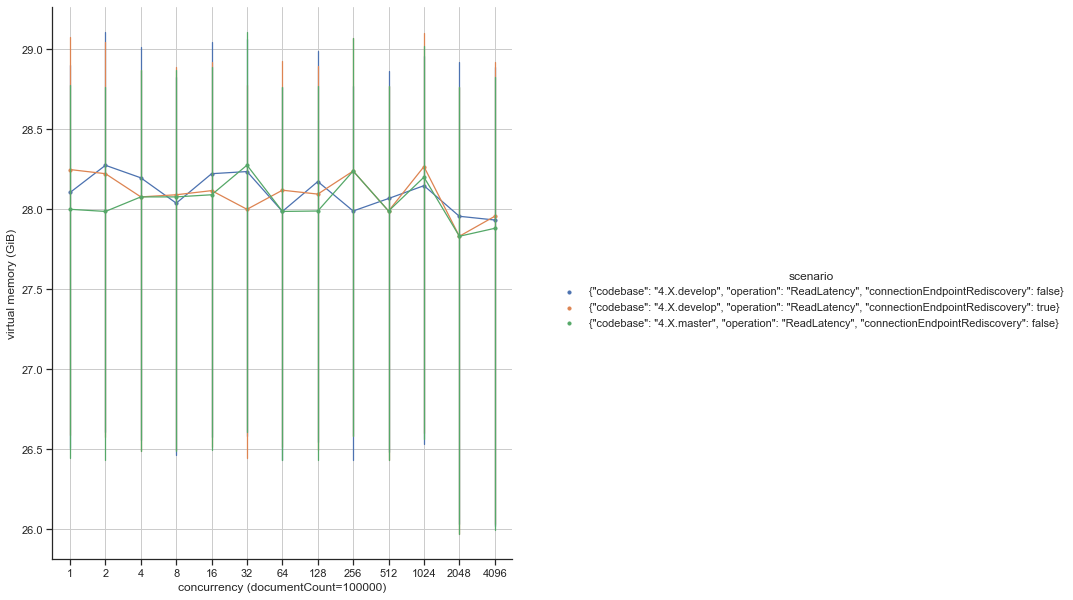

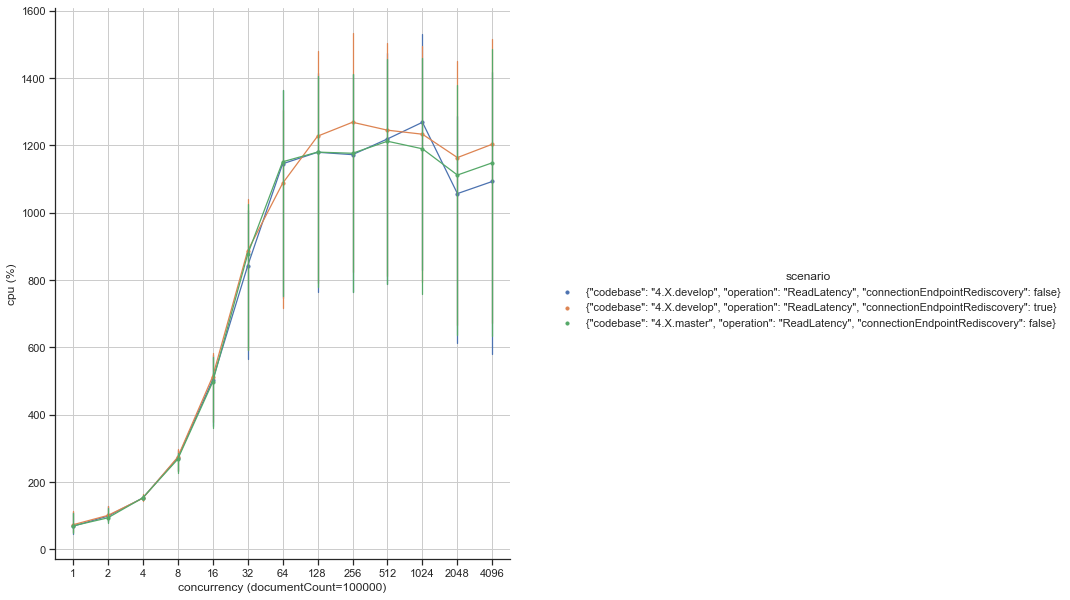

In [8]:
# Produce charts

seaborn.set(style='ticks', rc={
    'figure.max_open_warning': False,
    'lines.linewidth': 0.7})

concurrency_max: int = 4096
ci = 95

cwd = os.getcwd()

try:
    frame: DataFrame
    data: DataFrame
    filename: str
    output: str

    for data_set, data_tables in tables:

        # Performance

        frame = data_tables[0][0]
        filename: str = data_tables[0][1]
        output = path.dirname(filename)

        for document_count in [1, 100000]:

            data = frame[frame.concurrency.le(concurrency_max) & frame.documentCount.eq(document_count)]

            throughput_plot : seaborn.FacetGrid = seaborn.catplot(
                data=data,
                x='concurrency',
                y='mean_rate',
                ci=ci,
                height=8.5,
                hue='scenario',
                hue_order=sorted(data_set.scenarios()),
                kind='point',
                margin_titles=True)

            throughput_plot.savefig(
                path.join(output, 'throughput.documentCount={0:06d}.pdf'.format(document_count)),
                format='pdf',
                papertype='letter')

            latency_p95_plot : seaborn.FacetGrid = seaborn.catplot(
                data=data,
                x='concurrency',
                y='p95',
                ci=ci,
                height=8.5,
                hue='scenario',
                hue_order=sorted(data_set.scenarios()),
                kind='point',
                margin_titles=True)

            latency_p95_plot.savefig(
                path.join(output, 'latency-p95.documentCount={0:06d}.pdf'.format(document_count)),
                format='pdf',
                papertype='letter')

            latency_p99_plot : seaborn.FacetGrid = seaborn.catplot(
                data=data,
                x='concurrency',
                y='p99',
                ci=ci,
                height=8.5,
                hue='scenario',
                hue_order=sorted(data_set.scenarios()),
                kind='point',
                margin_titles=True)

            latency_p99_plot.savefig(
                path.join(output, 'latency-p99.documentCount={0:06d}.pdf'.format(document_count)),
                format='pdf',
                papertype='letter')

            latency_p999_plot : seaborn.FacetGrid = seaborn.catplot(
                data=data,
                x='concurrency',
                y='p999',
                ci=ci,
                height=8.5,
                hue='scenario',
                hue_order=sorted(data_set.scenarios()),
                kind='point',
                margin_titles=True)

            latency_p999_plot.savefig(
                path.join(output, 'latency-p999.documentCount={0:06d}.pdf'.format(document_count)),
                format='pdf',
                papertype='letter')

        # Network

        frame = data_tables[1][0]
        filename = data_tables[1][1]
        output = path.dirname(filename)

        for document_count in [1, 100000]:

            data = frame[frame.documentCount.eq(document_count)]

            socket_utilization_plot: seaborn.FacetGrid = seaborn.countplot(
                data=data,
                x='concurrency',
                hue='scenario',
                hue_order=sorted(data_set.scenarios()))

            pyplot.title(
                label='Socket counts by concurrency level (documentCount={0:n})\n\nSocket counts are summed over the set of observations taken at the end of each\nof five one minute periods in the test run. Socket counts were collected using ss.\nDivide the socket count by five to get the average count at the end of each period.\n'.format(document_count),
                loc='left')

            pyplot.legend([],[], frameon=False)
            pyplot.xlabel('concurrency')
            pyplot.ylabel('sockets')
            pyplot.grid(True)

            pyplot.savefig(
                path.join(output, 'socket_utilization.documentCount={0:06d}.pdf'.format(document_count)),
                format='pdf',
                papertype='letter')

            for concurrency in pandas.unique(data.concurrency[data.concurrency.le(concurrency_max)]):

                subset: DataFrame = pandas.crosstab(
                    index=data[data.concurrency.eq(concurrency)]['scenario'],
                    columns=data[data.concurrency.eq(concurrency)]['period']
                ).stack().to_frame().reset_index().rename(columns={0: 'sockets'})

                # print('concurrency: {0} = {1}; subset: {2} =\n{3}'.format(
                #     type(concurrency).__name__, concurrency,
                #     type(subset).__name__, subset))
                # print(subset.info(verbose=True))

                seaborn.FacetGrid = seaborn.catplot(
                    data=subset,
                    x='period',
                    y='sockets',
                    ci=ci,
                    height=8.5,
                    hue='scenario',
                    hue_order=sorted(data_set.scenarios()),
                    kind='bar',
                    margin_titles=True)

                pyplot.xlabel('period (concurrency={0}, documentCount={1})'.format(concurrency, document_count))

                pyplot.savefig(
                    path.join(output, 'socket_utilization.concurrency={0:04d}.documentCount={0:06d}.pdf'.format(concurrency, document_count)),
                    format='pdf',
                    papertype='letter')

        # Compute

        frame = data_tables[2][0]
        filename = data_tables[2][1]
        output = path.dirname(filename)

        for document_count in [1, 100000]:

            data = frame[frame.documentCount.eq(document_count)]

            # Virtual memory

            virtual_memory_plot : seaborn.FacetGrid = seaborn.catplot(
                data=data,
                x='concurrency',
                y='VIRT',
                ci=ci,
                height=8.5,
                hue='scenario',
                hue_order=sorted(data_set.scenarios()),
                kind='point',
                margin_titles=True)

            pyplot.xlabel('concurrency (documentCount={0})'.format(document_count))
            pyplot.ylabel('virtual memory (GiB)')
            pyplot.grid(True)

            virtual_memory_plot.savefig(
                path.join(output, 'virtual_memory.documentCount={0:06d}.pdf'.format(document_count)),
                format='pdf',
                papertype='letter')

            # CPU

            cpu_plot : seaborn.FacetGrid = seaborn.catplot(
                data=data,
                x='concurrency',
                y='%CPU',
                ci=ci,
                height=8.5,
                hue='scenario',
                hue_order=sorted(data_set.scenarios()),
                kind='point',
                margin_titles=True)

            pyplot.xlabel('concurrency (documentCount={0})'.format(document_count))
            pyplot.ylabel('cpu (%)')
            pyplot.grid(True)

            cpu_plot.savefig(
                path.join(output, 'cpu.documentCount={0:06d}.pdf'.format(document_count)),
                format='pdf',
                papertype='letter')
finally:
    os.chdir(cwd)